# Normalizing flows



Probability distributions are very common in physics, and normalizing flows ([arxiv:1908.09257](https://arxiv.org/abs/1908.09257), [arxiv:1912.02762](https://arxiv.org/abs/1912.02762)) provide a machine-learning method to extract probability distributions, for example, from samples of data.

The basic idea is to start with a "simple" distribution $p_u(u)$, for example a multi-dimensional gaussian, and to successively apply bijective differentiable transformations $T = T_n \circ T_{n-1} \circ \cdots \circ T_1$, so $x = T(u)$. The distribution of the transformed variable is given by the Jacobian of the transformation, $p_x(x) = |\det J_T(u)|^{-1} p_u(u)$. There are many possible choices for the transformations, but we are going to focus in affine coupling layers.

A coupling layer splits each input $x\in \mathbb{R}^d$ into two subspaces $(y, z)\in \mathbb{R}^{d_1} \times \mathbb{R}^{d_2}$ with $d_1 + d_2 = d$. $x_1$ is left unmodified, while $x_2$ is transformed element-wise by a parametric bijection $z \to h(z, \theta)$. The transformation is still a bijection if we choose $\theta$ as any arbitrary function of only $y$ (but not $z$). In the case of affine coupling layers, the transformation is
$$h \begin{pmatrix} y_i \\ z_j \end{pmatrix} = \begin{pmatrix} y_i \\ z_j \exp(s_j(y)) + t_j(y) \end{pmatrix} $$ 
where $s_j$ and $t_j$ are arbitrary, and usually defined by neural networks. Coupling layers allow for efficient evaluation of both $T$ and $T^{-1}$. But it is necessary to compose several coupling layers, and permuting the splits in subspaces, in order to reproduce arbitrary distributions.

For an application of normalizing flows to EFT fits, see [arxiv:2309.10365](https://arxiv.org/abs/2309.10365).

## Preparing the likelihood function

In [1]:
import numpy as np

We are going to perform a fit of the Wilson coefficients $C_9$ and $C_{10}$ using the observables $R_K$ and $BR(B_s\to \mu^+\mu^-)$. In order to speed things up, we are going to use polynomial models (see part 1 of the course) instead of the whole calculation with `flavio`. As you can see, $BR(B_s\to \mu^+\mu^-)$ only depends on $C_{10}$, as expected.

In [2]:
RK = lambda C9, C10: 1.00077063 + 0.23935628 * C9 - 0.25715944 * C10 + 0.03080949 * C9**2 +  0.03085803 * C10**2
Bsmumu = lambda C9, C10: 3.67233636e-09 + 1.39328234e-23 * C9 - 1.76279307e-09 * C10 + 1.91544011e-23 * C9**2 + 2.11543764e-10 * C10**2

RK_exp = 0.8838370861572656
RK_err = 0.02835853581829384

Bsmumu_exp = 3.0421025555256505e-09
Bsmumu_err = 1.2373122748395464e-10

The $\chi^2$ of the fit, neglecting correlation between both observables:

In [3]:
def chi2(C9, C10):
    return (RK_exp-RK(C9, C10))**2/RK_err**2 + (Bsmumu_exp-Bsmumu(C9, C10))**2/Bsmumu_err**2

Now we are going to use the Metropolis-Hastings MonteCarlo algorithm to generate samples of $(C_9, C_{10})$ that are distributed according to the $\chi^2$ of the fit. Note that in this algorithm, new points are accepted if the quotient of probabilities is $$\frac{P_\mathrm{new}}{P_\mathrm{old}} \geq u\,,$$
where $u$ is a uniform random number in $[0, 1]$. Since $P\sim e^{-\chi^2/2}$, we can express the Metropolis-Hastings condition as
$$\chi^2_\mathrm{new} \leq \chi^2_\mathrm{old} - 2 \log u$$

In [4]:
import random

def mc(N=1000):
    C9 = 0.0
    C10 = 0.0
    l = chi2(C9, C10)
    i = 0
    while i < N:
        accepted = False
        while accepted == False:
            C9test = C9 + random.gauss(0, 0.05)
            C10test = C10 + random.gauss(0, 0.05)
            u = random.uniform(0, 1)
            ltest = chi2(C9test, C10test)
            if ltest <= l - 2*np.log(u):
                accepted = True
        C9 = C9test
        C10 = C10test
        l = ltest
        i+=1
        yield C9, C10, l
            

In [5]:
C9list = []
C10list = []
llist = []

for C9, C10, l in mc(50000):
    C9list.append(C9)
    C10list.append(C10)
    llist.append(l)

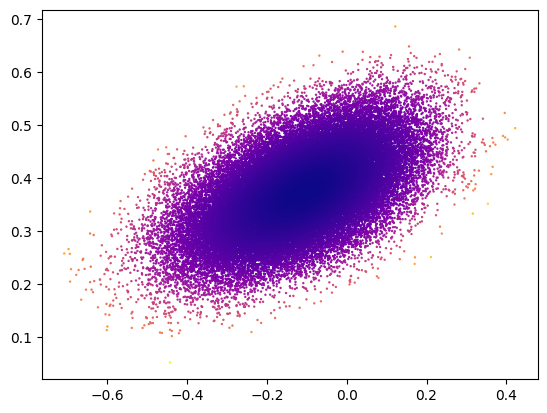

In [6]:
import matplotlib.pyplot as plt

plt.scatter(C9list[20:], C10list[20:], s=0.5, c=llist[20:], cmap="plasma")

## Using normalizing flows

We are going to use the normalizing flows implemented in the python package `normflows`, which is based on `torch`

```bash
pip install normflows
```

In [7]:
import normflows as nf
import torch
import tqdm

First we have to create the target distribution, wich is a subclass of `nf.distributions.Target`. We have to provide the number of dimensions and the maximum of the log-probability, and a method to compute the log-probability. In our case, we can simply use the `chi2`:

In [8]:
class Dist(nf.distributions.Target):
    def __init__(self):
        super().__init__()
        self.n_dims = 2
        self.max_log_prob = 0
    def log_prob(self, z):
        C9 = z[:, 0]
        C10 = z[:, 1]
        return -0.5*chi2(C9, C10)

In [9]:
target = Dist()

`nf.distributions.Target` already provides a method to sample the target distribution using an algorithm called Rejection Sampling. We could override it with our own sampling algorithm (e.g. the Metropolis-Hastings used previously), but it won't be necessary.

In [10]:
s1 = target.sample(10000)

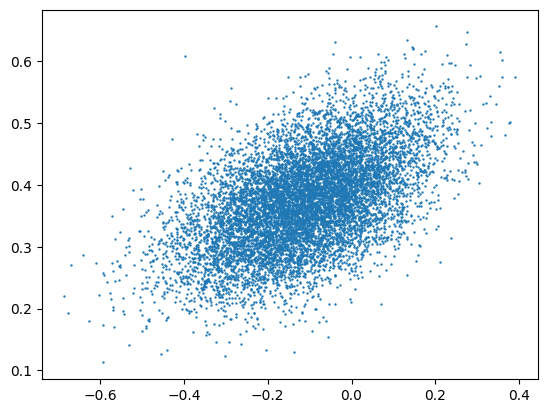

In [11]:
plt.scatter(s1[:,0], s1[:,1], s=0.5)

Here we define our flow, composed of `K=32` mapping layers. In each layer we use a mask `b` to select which parameters are affected by the affine flow: on even layers the even-numbered parameters and on odd layers the odd-numbered parameters. We use two MLPs `s` and `t` for scaling and translation in the affine flow, respectively.

In [12]:
# Define flows
K = 32

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

We define our base distribution as a two-dimensional gaussian, and prepare the flow, passing it to CUDA if available.

In [13]:
q0 = nf.distributions.DiagGaussian(2)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

Before starting, we compare the target distribution (contour lines) and the untrained posterior distribution (colors):

/root/.cache/pypoetry/virtualenvs/tfm-alejandromir-_L8EXmOG-py3.10/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


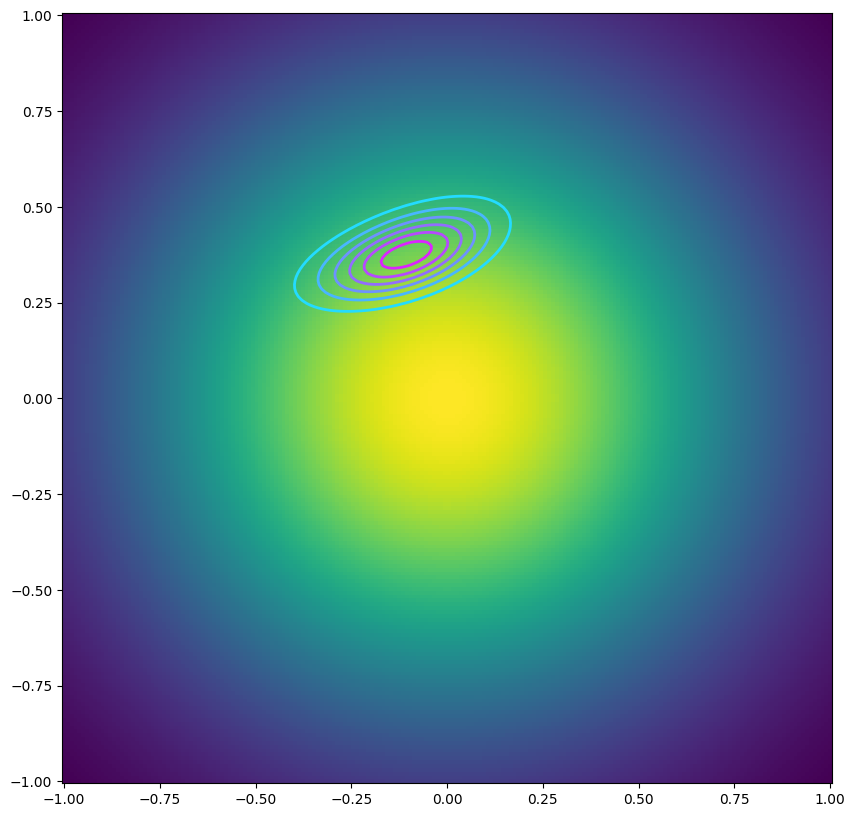

In [14]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-1, 1, grid_size), torch.linspace(-1, 1, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob_target = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

We train the posterior distribution using the `Adam` optimizer and the Kullback-Leibler (KL) divergence as loss function. The KL divergence (also known as relative entropy) measures how different is a probability distribution $P$ from a reference distribution $Q$, i.e. the information gained by using $P$ instead of $Q$. It is given by
$$D_\mathrm{KL}(P||Q) = \sum_{x\in X} P(x) \log \frac{P(x)}{Q(x)},$$
where $X$ is the sample.


We will plot the comparison to the target distribution at several intermediate steps:

 10%|▉         | 99/1000 [00:11<01:47,  8.35it/s]

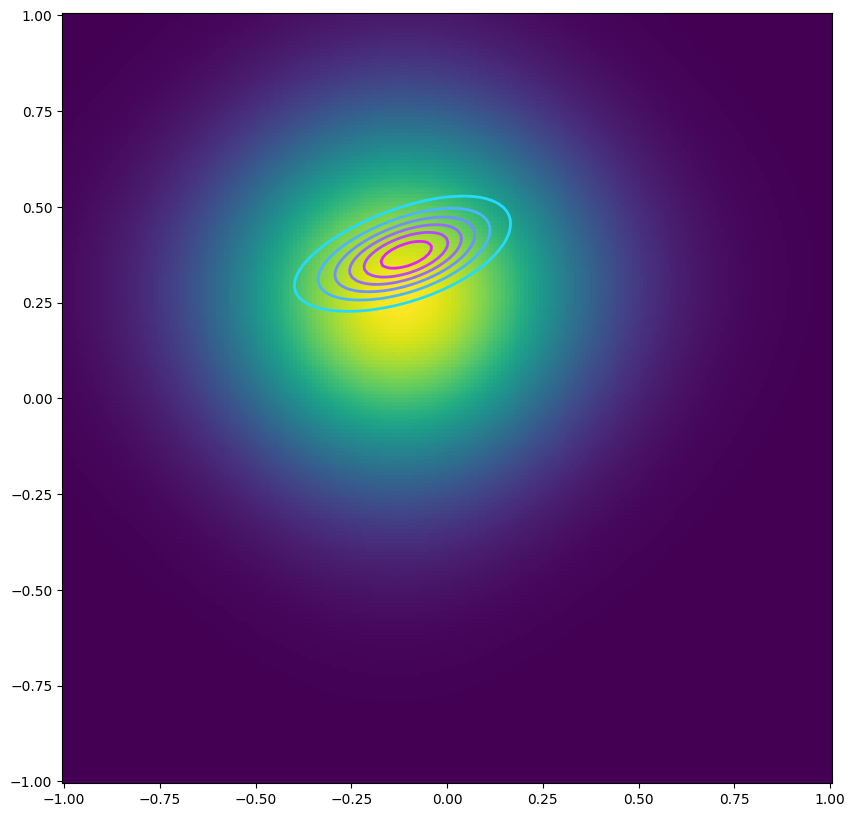

 20%|█▉        | 199/1000 [00:24<01:33,  8.55it/s]

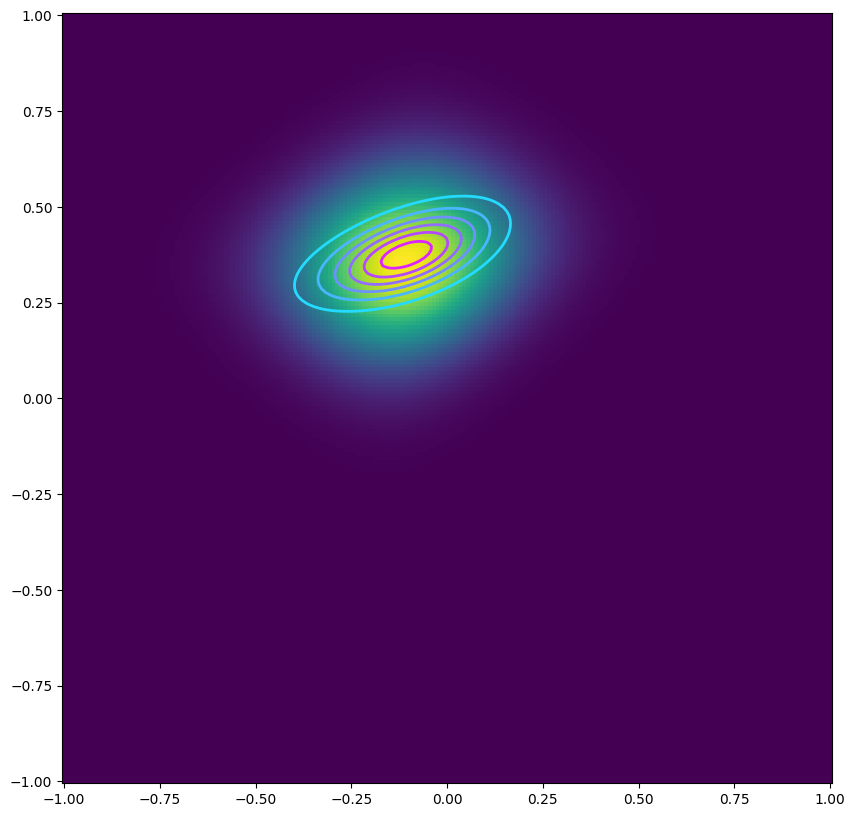

 30%|██▉       | 299/1000 [00:36<01:24,  8.30it/s]

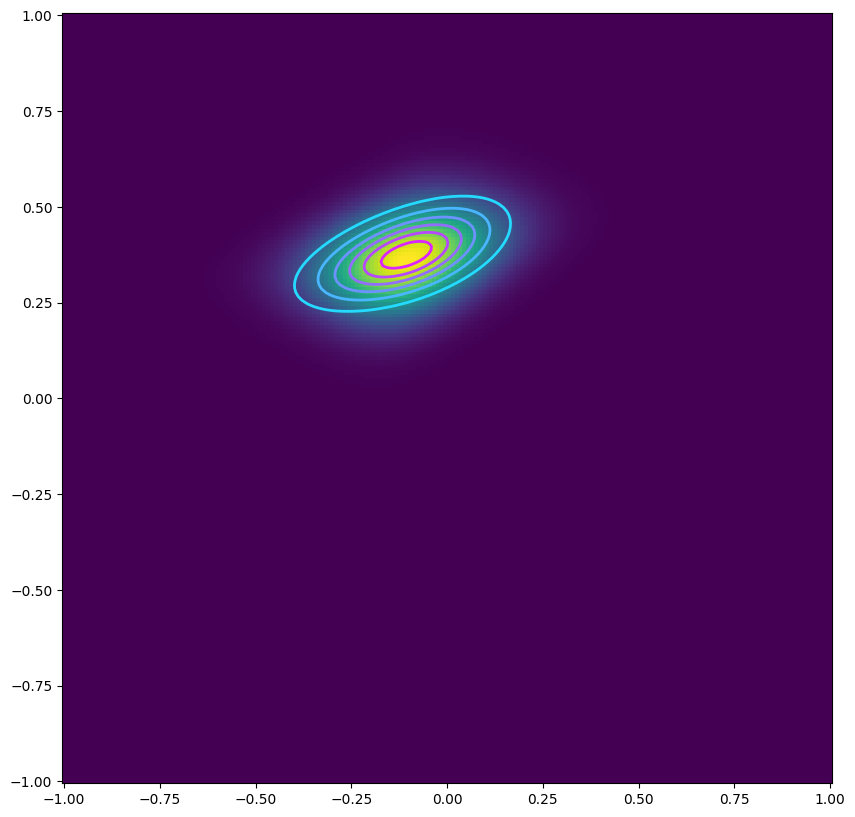

 40%|███▉      | 399/1000 [00:49<01:12,  8.27it/s]

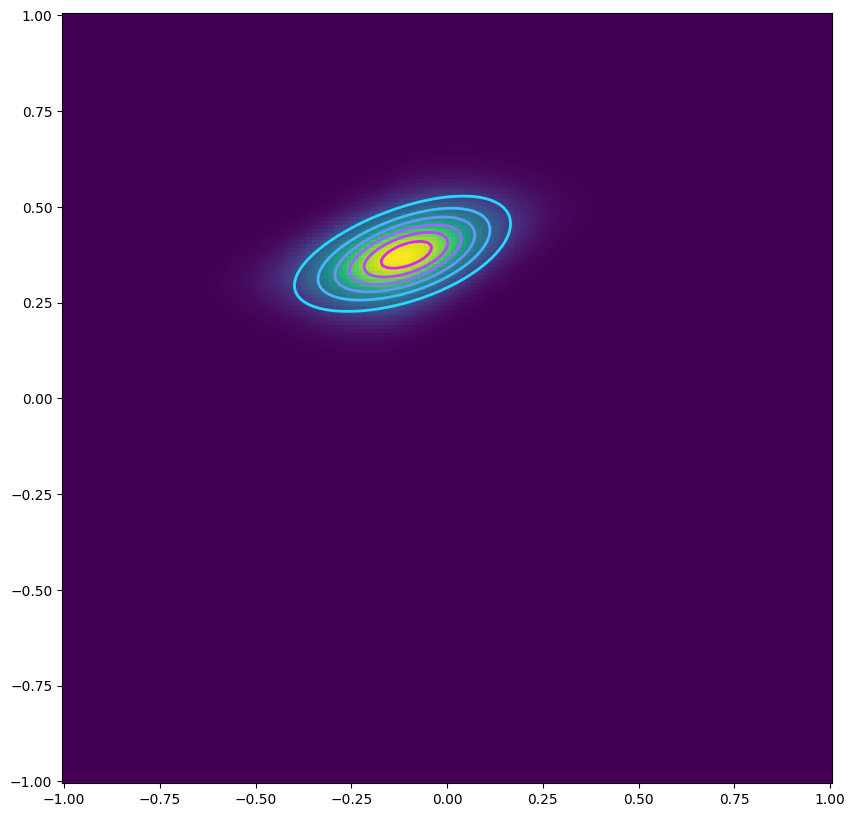

 50%|████▉     | 499/1000 [01:01<01:00,  8.23it/s]

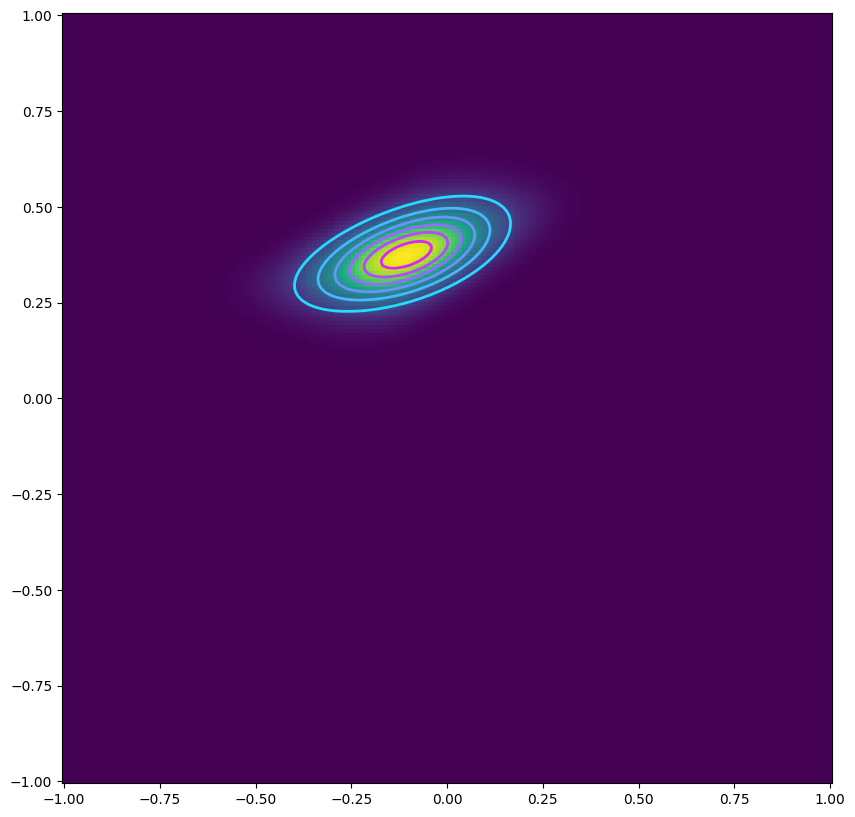

 60%|█████▉    | 598/1000 [01:14<00:45,  8.76it/s]

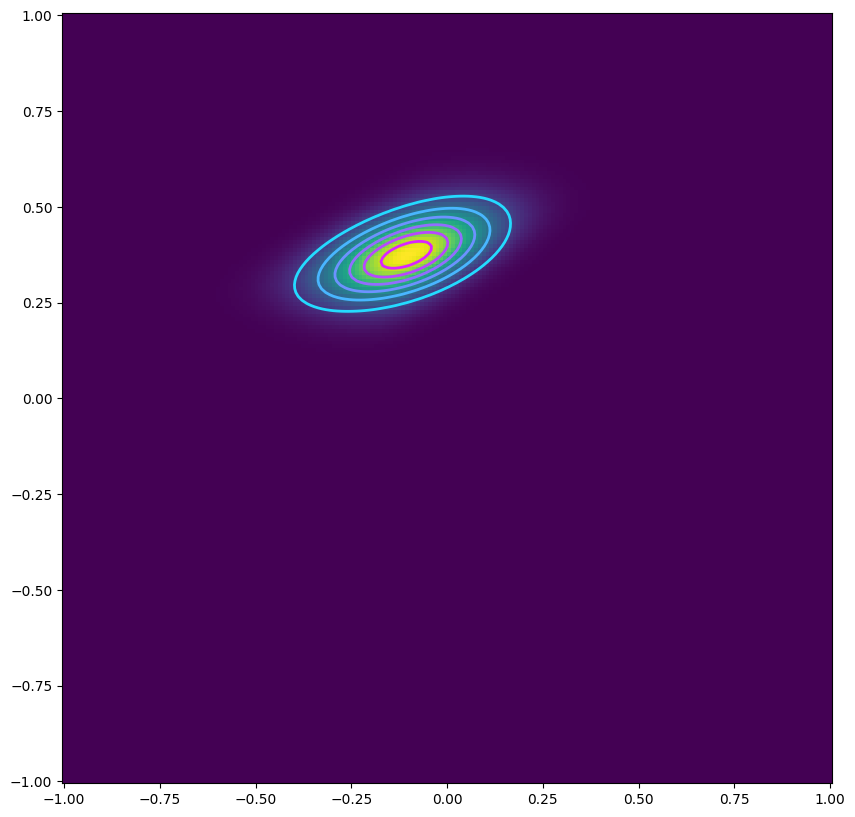

 70%|██████▉   | 699/1000 [01:26<00:35,  8.54it/s]

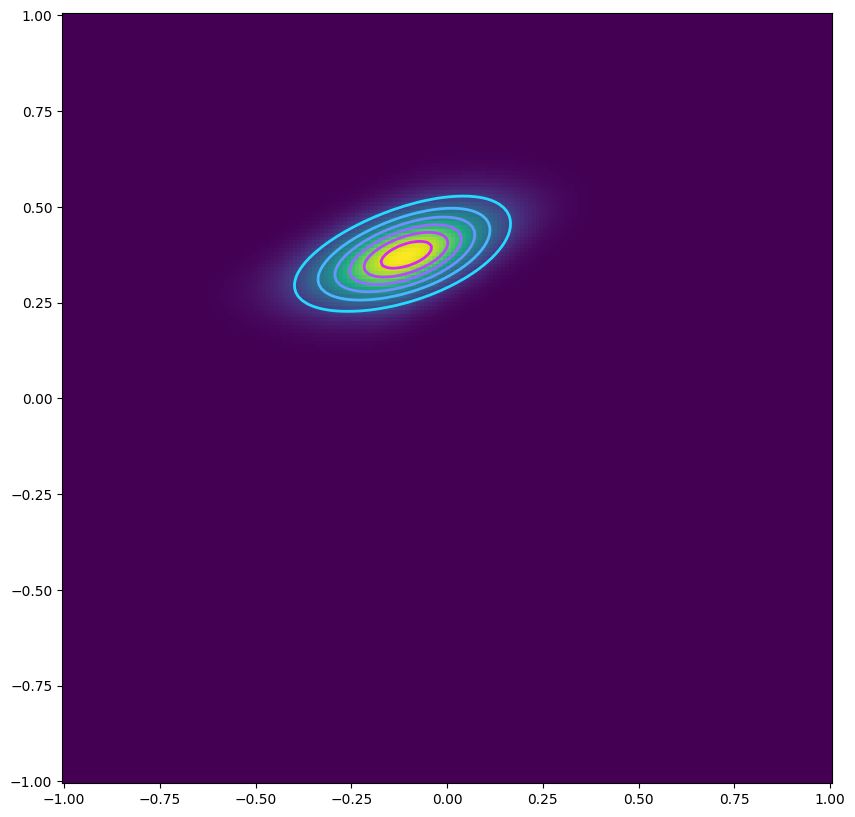

 80%|███████▉  | 799/1000 [01:39<00:25,  7.96it/s]

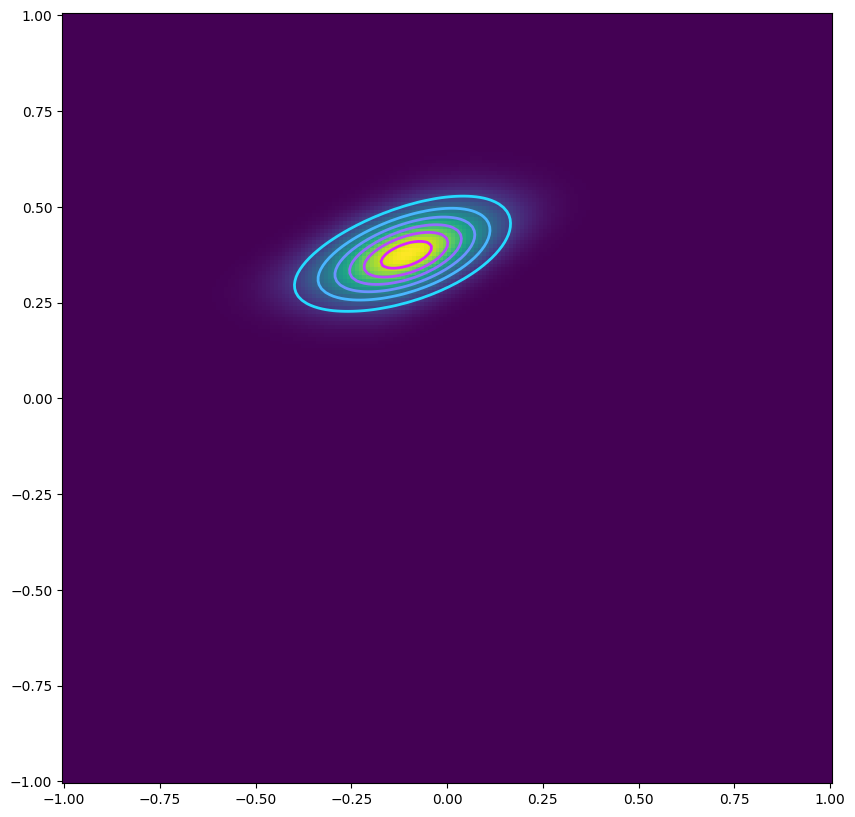

 90%|████████▉ | 899/1000 [01:52<00:11,  8.85it/s]

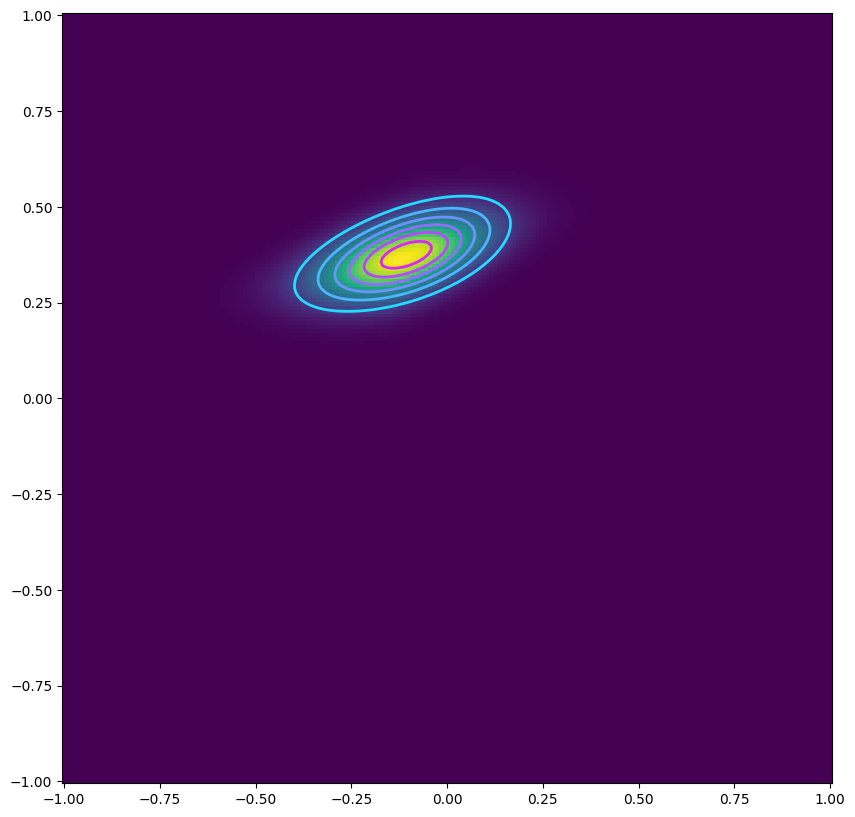

100%|█████████▉| 999/1000 [02:05<00:00,  7.69it/s]

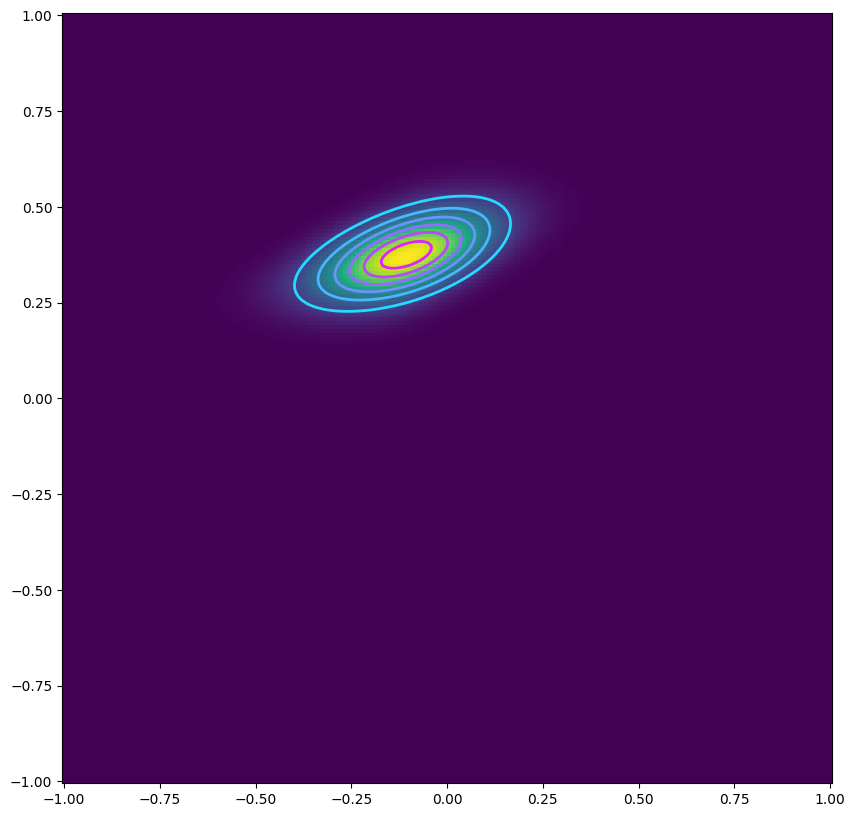

100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


In [15]:
# Train model
max_iter = 1000
num_samples = 2 * 10
show_iter = 100


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-6)
for it in tqdm.tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = nfm.forward_kld(target.sample(num_samples))
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(10, 10))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.contour(xx, yy, prob_target.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.show()



We see that the loss function first decreases rapidly, and then fluctuates. That means that we didn't need so many training steps.

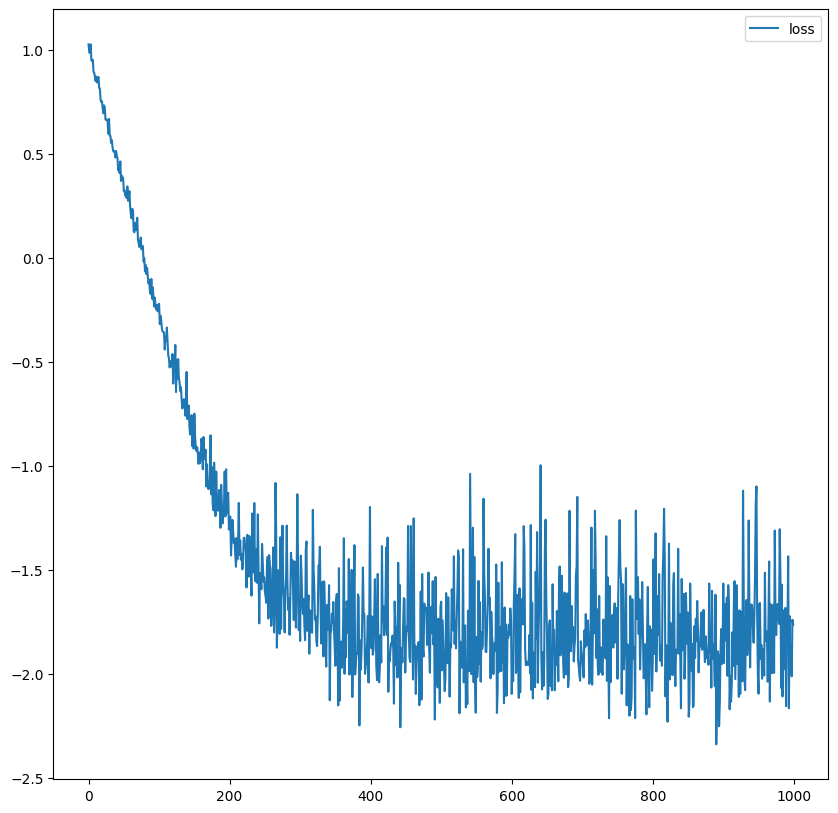

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

With the trained flow, we can map from the gaussian distribution to our likelihood with the method`forward`. For example, the best fit point corresponds to the point $(0,0)$ of the gaussian:

In [17]:
nfm.forward(torch.tensor([[0.0, 0.0]]))

tensor([[-0.1092,  0.3656]], dtype=torch.float64, grad_fn=<AddBackward0>)

We can also go in the opposite direction, from the target distribution to the gaussian. This is useful, for example, to obtain the significance of a point. Let us see if the SM ($C_9 = C_{10} = 0$) is allowed:

In [18]:
sm_point = nfm.inverse(torch.tensor([[0.0, 0.0]]))
norm = (sm_point[0, 0]**2+sm_point[0, 1]**2)**0.5

In [19]:
norm

tensor(6.1573, dtype=torch.float64, grad_fn=<PowBackward0>)

That is, the SM point is excluded by around $6\,\sigma$.

Let's compare this number with the exact calculation:

In [20]:
chi2_sm = chi2(0, 0)
chi2_bf = chi2(-0.1065, 0.3666)

In [21]:
import scipy

chi2_2 = scipy.stats.chi2(2)
cl = chi2_2.cdf(chi2_sm-chi2_bf)
scipy.stats.norm.ppf(0.5+cl/2)

6.2269875196161975